Sample notebook for the plotting functionality

In [1]:
## Imports
import sys
import os
import time
import math
import random

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Plotting import
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import the utils for plotting the metrics
from plot_utils import plot_utils
from plot_utils import notebook_utils_2

from sklearn.metrics import roc_curve, auc

In [15]:
# Dictionary mapping the ordinal labels to particle types 
LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}

# Fix the colour scheme for each particle type
COLOR_DICT = {"gamma":"red", "e":"blue", "mu":"green"}

Generic function to plot the training and validation log for each run

In [10]:
def plot_log(run_ids, model_ids, model_cls, keys, dumps_path, lgd_loc=(0.8,0.5), val=False, log=False, show=False, save_path=None):
    """Plot the logs for any model from saved .csv files
    
    Args:
    run_ids    -- List of run ids e.g. ["20191202_171757", ...] for each model to be plotted
    model_ids  -- Names of the models for which the log is being plotted
    model_cls  -- Two colors for each model for one axis on each size of the plot
    keys       -- Two keys for columns in the dataframe to plot (To generalize to the VAE)
    dumps_path -- Absolute path to the global dump folder
    log        -- Boolean to determine whether to use (log scaling) or not
    lgd_loc    -- Tuple to determine the location of the legend
    show       -- Boolean to determine whether to call plt.show()
    save_path  -- Absolute path of the location at which to save the plot
    """
    
    # Defensive assertions to prevent Nonetype error
    assert run_ids is not None
    assert model_ids is not None
    assert model_cls is not None
    assert dumps_path is not None
    
    # Defensive assertion to prevent breaking function usage
    assert len(run_ids) == len(model_ids)
    assert len(model_ids) == len(model_cls)
    assert len(keys) == 2
    
    # Extract the values stored in the .csv files
    train_epochs = []
    val_epochs = []
    
    train_0 = []
    train_1 = []
    
    val_0 = []
    val_1 = []
    
    dumps_path = dumps_path + "/" if not dumps_path.endswith("/") else dumps_path
    dump_dirs = [dumps_path + run_id + "/" for run_id in run_ids]
    
    # Iterate over the logs for all the models
    for dump_dir in dump_dirs:
        
        train_log_path = dump_dir + "log_train.csv"
        val_log_path = dump_dir + "log_val.csv"
        
        if os.path.exists(train_log_path) and os.path.exists(val_log_path):
            train_log_df = pd.read_csv(train_log_path, usecols=["epoch",keys[0],keys[1]])
            if val:
                val_log_df = pd.read_csv(val_log_path, usecols=["epoch",keys[0],keys[1]])
            
        train_epochs.append(train_log_df["epoch"].values)
        train_0.append(train_log_df[keys[0]].values)
        train_1.append(train_log_df[keys[1]].values)
        
        if val:
            val_epochs.append(val_log_df["epoch"].values)
            val_0.append(val_log_df[keys[0]].values)
            val_1.append(val_log_df[keys[1]].values)
     
    # Initialize the plot
    fig, ax1 = plt.subplots(figsize=(16,11))
    ax2 = ax1.twinx()
    
    # Print the mpl rcParams
    mpl.rcParams['agg.path.chunksize']=1e12
    
    # Reload the backend
    mpl.use(mpl.get_backend())
    
    for i, model_ids in enumerate(model_ids):
        if val:
            ax1.plot(train_epochs[i], train_0[i], color=model_cls[i][0], alpha=0.3, linewidth=1.0)
            ax2.plot(train_epochs[i], train_1[i], color=model_cls[i][1], alpha=0.3, linewidth=1.0)
            
            ax1.plot(val_epochs[i], val_0[i], color=model_cls[i][0], label=model_ids+" "+keys[0], alpha=1.0, linewidth=1.0)
            ax2.plot(val_epochs[i], val_1[i], color=model_cls[i][1], label=model_ids+" "+keys[1], alpha=1.0, linewidth=1.0)
        else:
            ax1.plot(train_epochs[i], train_0[i], color=model_cls[i][0], label=model_ids+" "+keys[0], alpha=0.3, linewidth=1.0)
            ax2.plot(train_epochs[i], train_1[i], color=model_cls[i][1], label=model_ids+" "+keys[1], alpha=0.3, linewidth=1.0)
    
    if log:
        ax1.set_yscale("log")
        ax2.set_yscale("log")
    
    # Setup plot characteristics
    ax1.tick_params(axis="x", labelsize=30)
    ax1.set_xlabel("Epoch", fontsize=30)
    
    ax1.set_ylabel(keys[0], fontsize=30, color=model_colors[0][0])
    ax1.tick_params(axis="y", labelsize=30, color=model_colors[0][0])
    
    ax2.set_ylabel(keys[1], fontsize=30, color=model_colors[0][1])
    ax2.tick_params(axis="y", labelsize=30, color=model_colors[0][1])
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    
    lgd = plt.legend(lines1 + lines2, labels1 + labels2, prop={"size":30},
                     loc="upper right", bbox_to_anchor=lgd_loc, frameon=True,
                     fancybox=True, shadow=True, framealpha=1.0)
    
    ax1.grid(True, which="both", axis="both")
    ax2.grid(True, which="both", axis="both")
    
    plt.margins(0.2)
    
    if save_path is not None:
        plt.savefig(save_path, format='pdf', dpi=600, bbox_extra_artists=(lgd))
    if show:
        try:
            plt.show()
        except:
            print("plot_log() : Unable to render the plot due to limits on \'agg.path.chunksize\')")
            if save_path is None:
                print("plot_log() : Saving plot to ./{0}".format("vae_training_log.pdf"))
                plt.savefig(save_path, format='pdf', dpi=600, bbox_extra_artists=(lgd))
            plt.clf()
            plt.close()
    else:
        plt.clf()
        plt.close()

Plot the training and validation log from the saved .csv files

One plot for each training run

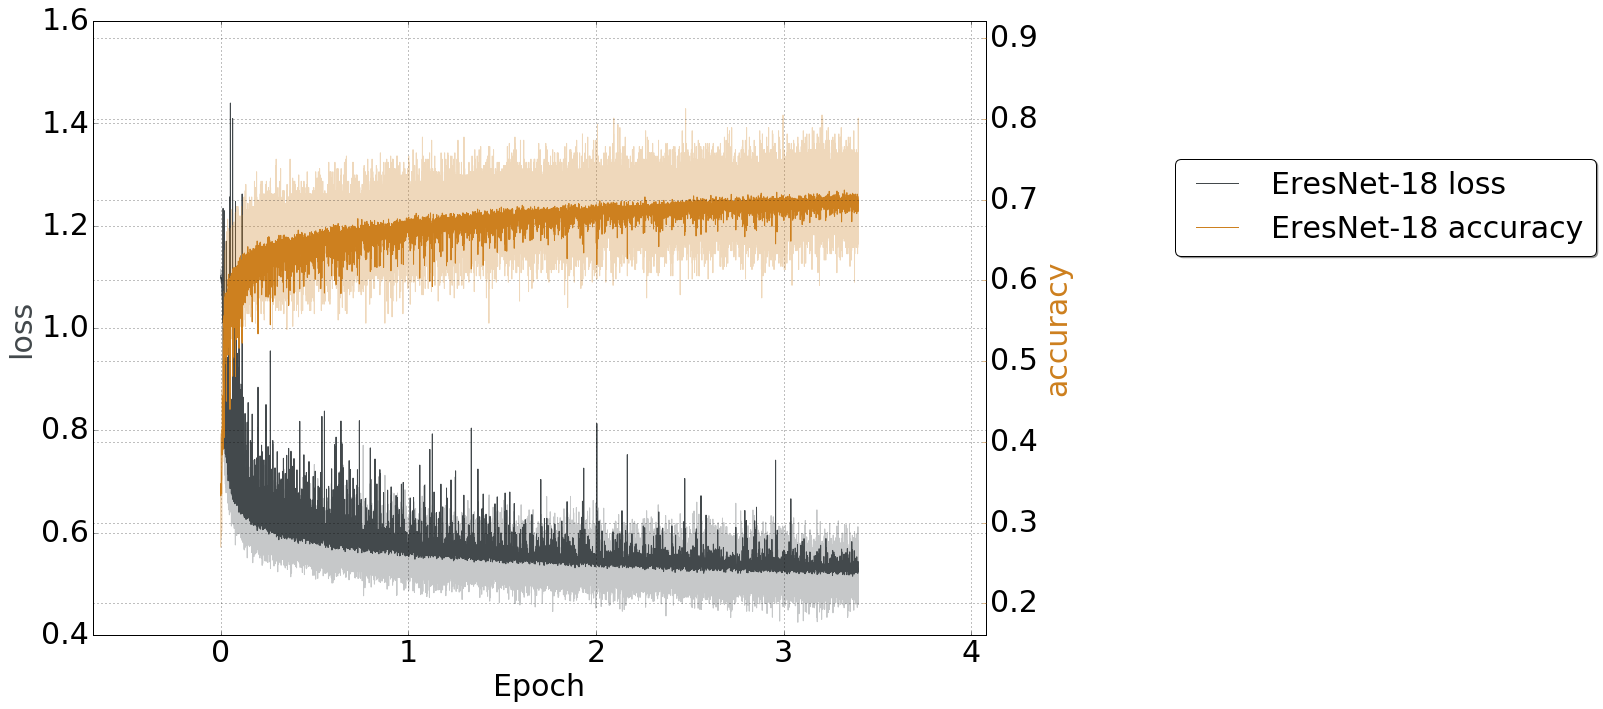

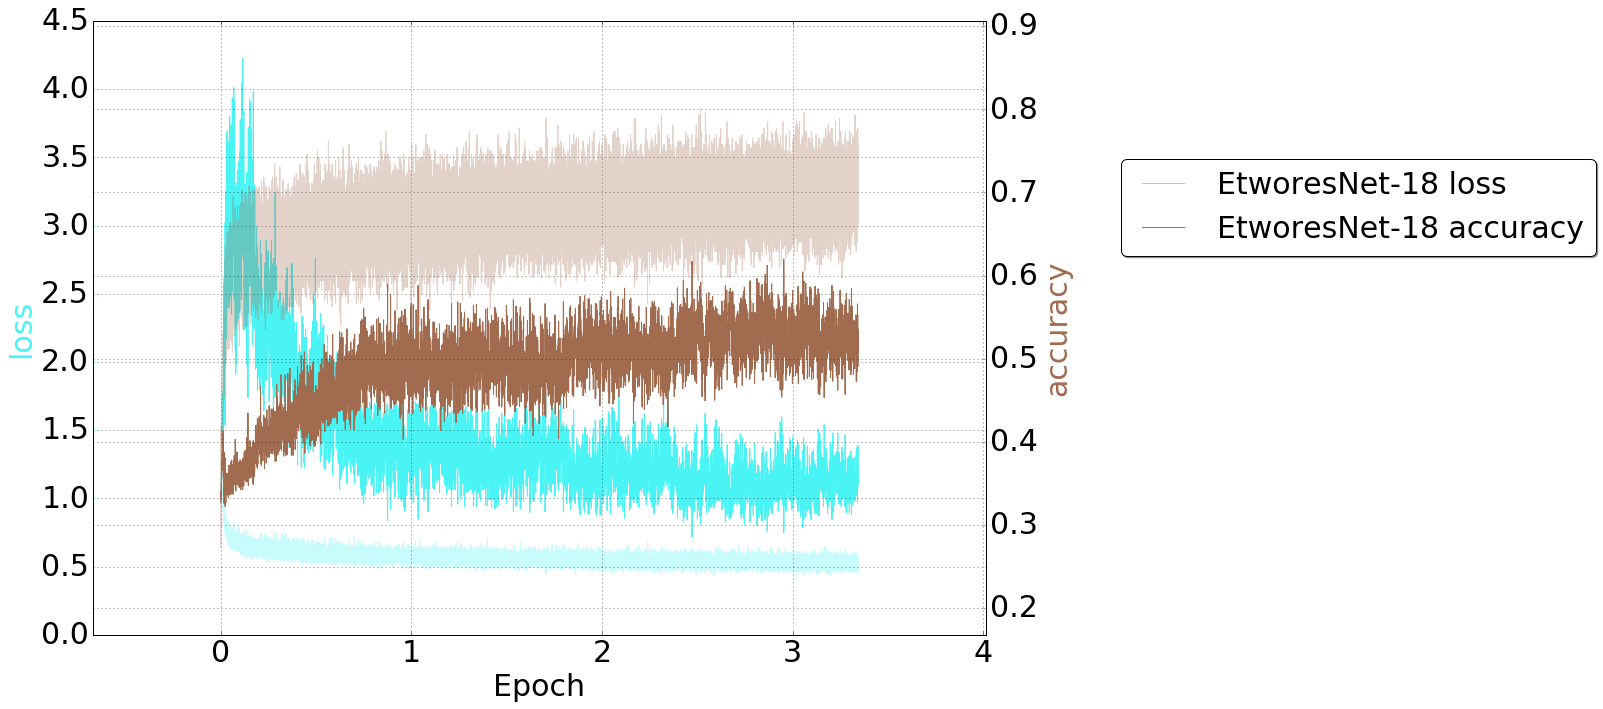

In [11]:
dumps_path = "/home/akajal/WatChMaL/VAE/dumps/"
run_ids = [["20191202_095740"], ["20191202_095803"]]
model_ids = [["EresNet-18"], ["EtworesNet-18"]]

for run_id, model_id in zip(run_ids, model_ids):
    model_colors = [(np.random.rand(3,), np.random.rand(3,)) for model in model_id]
    keys = ["loss", "accuracy"]

    plot_log(run_id, model_id, model_colors, keys, dumps_path, lgd_loc=(1.7, 0.8), val=True, log=False, show=True)

One plot for all the training runs

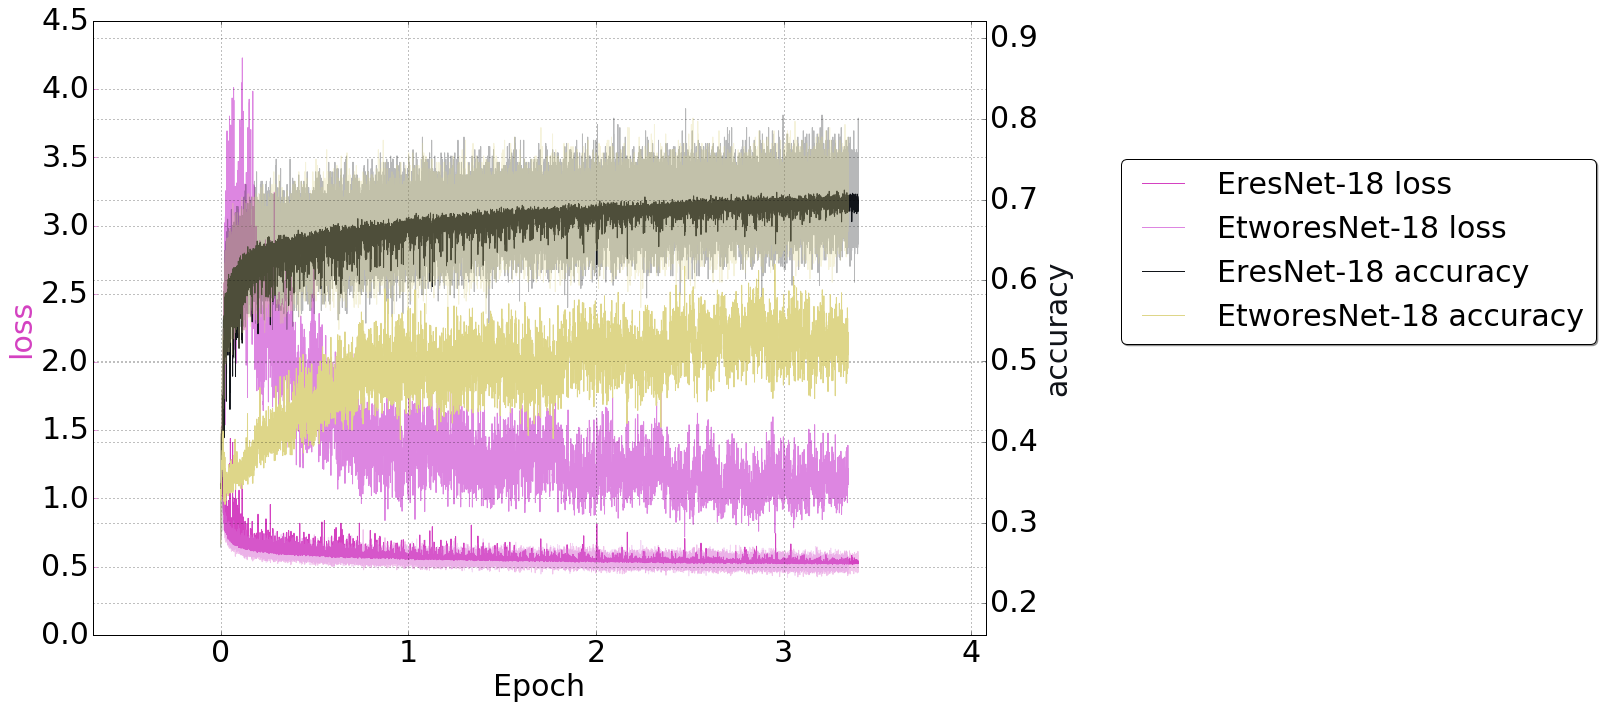

In [13]:
dumps_path = "/home/akajal/WatChMaL/VAE/dumps/"
run_ids = ["20191202_095740", "20191202_095803"]
model_ids = ["EresNet-18", "EtworesNet-18"]

# Can also specify the colours manually for consistency
model_colors = [(np.random.rand(3,), np.random.rand(3,)) for model in model_ids]
keys = ["loss", "accuracy"]

plot_log(run_ids, model_ids, model_colors, keys, dumps_path, lgd_loc=(1.7, 0.8), val=True, log=False, show=True)

Generic function to plot the ROC (Efficiency vs Background rejection)

In [16]:
# Plot the ROC curve for one vs another class
def plot_new_ROC(softmaxes, labels, energies, softmax_index_dict, label_0, label_1, 
                 min_energy=0, max_energy=1500, show_plot=False, save_path=None):
    
    """Plot the signal efficiency vs. background rejection from softmax output
    
    softmaxes          -- 2D np array with shape (num_examples, num_classes)
    labels             -- 1D np array with true ordinal labels e.g. [0,1,2,0,1,...]
    energies           -- 1D np array with true energies for each event
    softmax_index_dict -- Dictionary mapping str class ids e.g. "gamma" to axis=1 idx
                          in the softmax array
    label_0            -- str class id for the signal class e.g. "e"
    label_1            -- str class id for the background class e.g. "gamma"
    min_energy         -- Minimum energy of the events to consider when plot the signal
                          efficiency vs background rejection plots
    max_energy         -- Maximum energy of the events to consider when plot the signal
                          efficiency vs background rejection plots
    show               -- Boolean to determine whether to call plt.show()
    save_path          -- Absolute path of the location at which to save the plot        
    """
    
    assert softmaxes is not None
    assert labels is not None
    assert softmax_index_dict  is not None
    assert softmaxes.shape[0] == labels.shape[0]
    assert label_0 in softmax_index_dict.keys()
    assert label_1 in softmax_index_dict.keys()
    
    #------------------------------------------------------------------------
    # Create a boolean map to select events in the user-defined energy range
    #------------------------------------------------------------------------
    
    energy_slice_map = [False for i in range(len(energies))]
    
    for i in range(len(energies)):
        if(energies[i] >= min_energy and energies[i] < max_energy):
                energy_slice_map[i] = True
                
    curr_softmax = softmaxes[energy_slice_map]
    curr_labels = labels[energy_slice_map]
    
    #------------------------------------------------------------------------
    # Extract the softmax and true label values for signal and background events
    #------------------------------------------------------------------------
    
    # Extract the useful softmax and labels from the input arrays
    softmax_0 = curr_softmax[curr_labels==softmax_index_dict[label_0]]
    labels_0 = curr_labels[curr_labels==softmax_index_dict[label_0]] 
    
    softmax_1 = curr_softmax[curr_labels==softmax_index_dict[label_1]]
    labels_1 = curr_labels[curr_labels==softmax_index_dict[label_1]]
    
    # Add the two arrays
    softmax = np.concatenate((softmax_0, softmax_1), axis=0)
    labels = np.concatenate((labels_0, labels_1), axis=0)

    #------------------------------------------------------------------------
    # Compute the ROC curve and the AUC for class corresponding to label 0
    #------------------------------------------------------------------------
    
    fpr, tpr, threshold = roc_curve(labels, softmax[:,softmax_index_dict[label_0]], pos_label=softmax_index_dict[label_0])
    roc_auc = auc(fpr, tpr)
    
    inv_fpr = []
    for i in fpr:
        inv_fpr.append(1/i) if i != 0 else inv_fpr.append(1/1e-5)
        
    tnr = 1. - fpr
    
    if show_plot or save_path is not None:
        
        # TNR vs TPR plot
        fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
        ax.tick_params(axis="both", labelsize=20)

        ax.plot(tpr, inv_fpr, color=COLOR_DICT[label_1],
                 label=r"$\{0}$, AUC ${1:0.3f}$".format(label_0, roc_auc) if label_0 is not "e" else r"${0}$, AUC ${1:0.3f}$".format(label_0, roc_auc),
                 linewidth=1.0, marker=".", markersize=4.0, markerfacecolor=COLOR_DICT[label_1])

        # Show coords of individual points near x = 0.2, 0.5, 0.8
        todo = {0.2: True, 0.5: True, 0.8: True}
        for xy in zip(tpr, inv_fpr, tnr):
            xy = (round(xy[0], 4), round(xy[1], 4), round(xy[2], 4))
            xy_plot = (round(xy[0], 4), round(xy[1], 4))
            for point in todo.keys():
                if xy[0] >= point and todo[point]:
                    ax.annotate('(%s, %s, %s)' % xy, xy=xy_plot, textcoords='data', fontsize=18, bbox=dict(boxstyle="square", fc="w"))
                    todo[point] = False

        ax.grid(True, which='both', color='grey')
        xlabel = r"$\{0}$ signal efficiency".format(label_0) if label_0 is not "e" else r"${0}$ signal efficiency".format(label_0)
        ylabel = r"$\{0}$ background rejection".format(label_1) if label_1 is not "e" else r"${0}$ background rejection".format(label_1)

        ax.set_xlabel(xlabel, fontsize=20) 
        ax.set_ylabel(ylabel, fontsize=20)

        ax.set_title(r"${0} \leq E < {1}$".format(round(min_energy,2), round(max_energy,2)), fontsize=20)
        ax.legend(loc="upper right", prop={"size":20})
        
        plt.margins(0.1)
        plt.yscale("log")
        
    if save_path is not None:
        plt.savefig(save_path)
    
    if show_plot:
        plt.show()
        
    plt.clf() # Clear the current figure
    plt.close() # Close the opened window
        
        
    return fpr, tpr, threshold, roc_auc

Plot signal efficiency vs background rejection plots

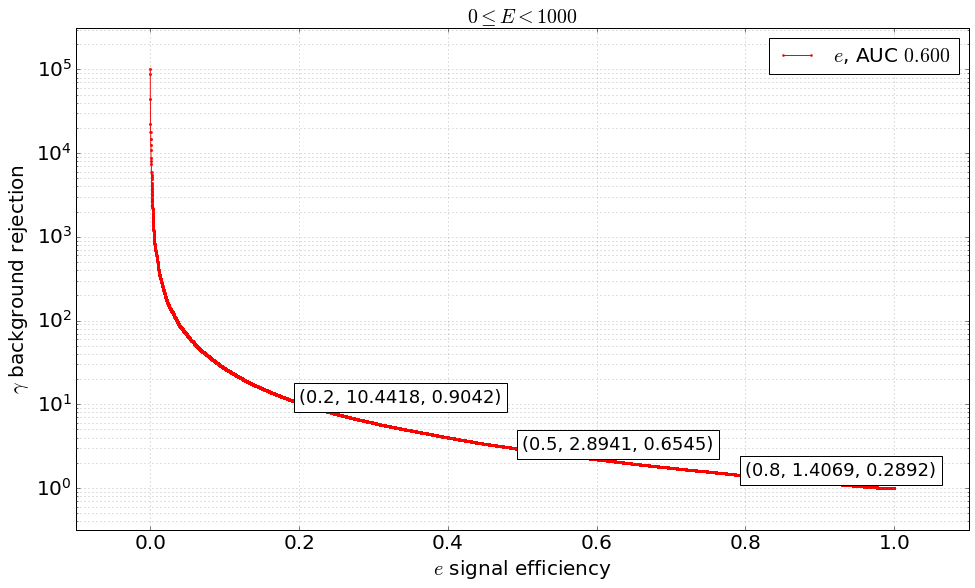

In [17]:
run_ids = ["20191204_112703"]

dump_dir = "/home/akajal/WatChMaL/VAE/dumps/"
dump_file = "/val_valid_iteration_dump.npz"

softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

for run_id in run_ids:
    
    test_dump_path = dump_dir + run_id + dump_file
    test_dump_np = np.load(test_dump_path)
    
    test_softmax  = test_dump_np['softmax'].reshape(-1, 3)
    test_labels   = test_dump_np['labels'].reshape(-1)
    test_energies = test_dump_np['energies'].reshape(-1)
    
    roc_metrics = plot_new_ROC(test_softmax, test_labels, test_energies,
                               softmax_index_dict, "e", "gamma", min_energy=0,
                               max_energy=1000, show_plot=True)